### Install needs

In [268]:
# pip install biopython bio networkx

### Imports

In [269]:
from Bio import SeqIO
from collections import defaultdict
from itertools import product
from scipy.linalg import expm
from Bio import Phylo
import networkx as nx
import math

### Stockholm to Phylip format conversion
https://www.hiv.lanl.gov/content/sequence/FORMAT_CONVERSION/form.html

### Get Maximum Likelihood phylogenetic tree
http://www.atgc-montpellier.fr/phyml/

### Get From files

##### Sequences

In [270]:
def read_sequences (filename: str):
    first_ln = False
    num_seq = 0
    len_seq = 0
    
    seq_dict = defaultdict(str)
    
    with open(filename) as file:
        for line in file:
            line = line.strip().split()
            if len(line) == 2:
                if first_ln == False:
                    num_seq = int(line[0])
                    len_seq = int(line[1])
                    first_ln = True
                else:
                    if len(line[1]) == len_seq and num_seq != 0:
                        seq_dict[line[0]] = line[1]
                        num_seq -= 1
                    else: 
                        raise ValueError("Invalid file structure")
    return seq_dict

##### Tree

In [271]:
def clade_names_fix(tree):
    for index, clade in enumerate(tree.find_clades()):
        if not clade.name:
            if index == 0:
                clade.name = "root"
            else:
                clade.name = str(index)

def read_tree(filename: str):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    return Phylo.to_networkx(Tree)

##### Structure

In [272]:
def read_structure(filename: str):
    with open(filename) as file:
        return file.readline().strip()

In [273]:
def simplify_struct(structure: str, filename=""):
    pairing_chars = ["<", ">", "(", ")", "[", "]", "{", "}"]
    simplified = ""
    for i in range(len(structure)):
        if structure[i] in pairing_chars:
            simplified += "d "
        else:
            simplified += "s "
    if filename != "":        
        with open(f"{filename}.train", "w+") as file:
            file.write(simplified)
    
    return simplified

### Validate Sequence String

In [274]:
def is_valid_chars(input_string, valid_characters):
    for char in input_string:
        if char not in valid_characters:
            return False
    return True

### Calculate frequency

In [275]:
def calc_frequencies (seq_dict: defaultdict, structure, legal_chars = ["A", "C", "G", "U", "-"]):
    single_nucleotides = defaultdict(int)
    paired_nucleotides = defaultdict(int)
    
    total_singles = 0
    total_paireds = 0
    
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    unpaired_nucleotides = []
    
    for _, sequence in seq_dict.items():
        for index, nucleotide in enumerate(sequence): 
            if structure[index] in [p[0] for p in pairing_chars]:
                unpaired_nucleotides.append((structure[index], nucleotide))
            elif structure[index] in [p[1] for p in pairing_chars]:
                char_index = [idx for idx, val in enumerate(pairing_chars) if val[1] == structure[index]][0]
                unpaired_nucleotide = unpaired_nucleotides.pop()
                if unpaired_nucleotide[0] == pairing_chars[char_index][0]:
                    paired_nucleotide = unpaired_nucleotide[1] + nucleotide
                    if is_valid_chars(paired_nucleotide, legal_chars):
                        paired_nucleotides[unpaired_nucleotide[1] + nucleotide] += 1
                        paired_nucleotides[nucleotide + unpaired_nucleotide[1]] += 1
                        total_paireds += 1
            else:
                if is_valid_chars(nucleotide, legal_chars):
                    single_nucleotides[nucleotide] += 1
                    total_singles += 1
    
    total = total_singles + total_paireds
                
    for key, value in single_nucleotides.items():
        single_nucleotides[key] = value / total_singles
    for key, value in paired_nucleotides.items():
        paired_nucleotides[key] = value / total_paireds
        
    return single_nucleotides, paired_nucleotides, total_singles / total, total_paireds / total

### Find time two sequences

In [276]:
def find_node_by_name(graph, name_str):
    return [node for _, node in enumerate(list(graph.nodes)) if node.name==name_str][0]

In [277]:
def calculate_time(graph, sourceName, targetName):
    return nx.shortest_path_length(
            graph, 
            source= find_node_by_name(graph, sourceName), 
            target= find_node_by_name(graph, targetName), 
            weight= "weight"
        )

### Simularity Percentage

In [278]:
def check_simularity(seq1:str, seq2:str):
    simularity = 0
    if len(seq1) == len(seq2):
        for i in range(len(seq1)):
            if seq1[i] == seq2[i]:
                simularity += 1
        return simularity / len(seq1) >= .85

### Calculate Rate Matrix
$$r_{XY}=\frac{c_{XY}}{2p_xP_s\sum_{P} N_Pt_P}$$

In [279]:
def calc_rate_matrix(graph, seq_dict: defaultdict, structure, single_frequencies, paired_frequencies, singles_prob, paireds_prob, legal_chars = ["A", "C", "G", "U", "-"]):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    seq_list = [(k, v) for k, v in seq_dict.items()]
    tp_sumation = 0
    unpaired_nucleotides = []
    
    single_mutation_count = defaultdict(int)
    paired_mutation_count = defaultdict(int)
    
    for i in range(len(seq_list)):
        for j in range(i+1, len(seq_list)):
            if check_simularity(seq_list[i][1], seq_list[j][1]):
                for k in range(len(seq_list[i][1])): 
                    if structure[k] in [p[0] for p in pairing_chars]:
                        unpaired_nucleotides.append((structure[k], seq_list[i][1][k], seq_list[j][1][k]))
                    elif structure[k] in [p[1] for p in pairing_chars]:
                        char_index = [idx for idx, val in enumerate(pairing_chars) if val[1] == structure[k]][0]
                        unpaired_nucleotide = unpaired_nucleotides.pop()
                        if unpaired_nucleotide[0] == pairing_chars[char_index][0]:
                            if seq_list[i][1][k] + unpaired_nucleotide[1] != seq_list[j][1][k] + unpaired_nucleotide[2]:
                                if is_valid_chars(seq_list[i][1][k] + unpaired_nucleotide[1], legal_chars) and is_valid_chars(seq_list[j][1][k] + unpaired_nucleotide[2], legal_chars):
                                    paired_mutation_count[(seq_list[i][1][k] + unpaired_nucleotide[1], seq_list[j][1][k] + unpaired_nucleotide[2])] += 1
                                    paired_mutation_count[(seq_list[j][1][k] + unpaired_nucleotide[2], seq_list[i][1][k] + unpaired_nucleotide[1])] += 1
                                    paired_mutation_count[(unpaired_nucleotide[1] + seq_list[i][1][k], unpaired_nucleotide[2] + seq_list[j][1][k])] += 1
                                    paired_mutation_count[(unpaired_nucleotide[2] + seq_list[j][1][k], unpaired_nucleotide[1] + seq_list[i][1][k])] += 1
                    else:
                        if seq_list[i][1][k] != seq_list[j][1][k]:
                            if is_valid_chars(seq_list[i][1][k], legal_chars) and is_valid_chars(seq_list[j][1][k], legal_chars):
                                single_mutation_count[(seq_list[i][1][k], seq_list[j][1][k])] += 1
                                single_mutation_count[(seq_list[j][1][k], seq_list[i][1][k])] += 1
                tp_sumation += calculate_time(graph, seq_list[i][0], seq_list[j][0])
                
    single_chars = legal_chars
    paired_chars = [c1 + c2 for c1 in single_chars for c2 in single_chars]
    
    single_rate_matrix = defaultdict(float)
    paired_rate_matrix = defaultdict(float)
            
    for i in single_chars:
        single_rate_matrix[(i,i)] = 0
        for j in single_chars:
            if i != j:
                single_rate_matrix[(i,j)] = single_mutation_count[(i,j)] / (singles_prob * single_frequencies[i] * tp_sumation * len(structure))
                single_rate_matrix[(i,i)] = single_rate_matrix[(i,i)] - single_rate_matrix[(i,j)]
    for i in paired_chars:
        paired_rate_matrix[(i,i)] = 0
        for j in paired_chars:
            if i != j:
                paired_rate_matrix[(i,j)] = paired_mutation_count[(i,j)] / (paireds_prob * paired_frequencies[i] * tp_sumation * len(structure))
                paired_rate_matrix[(i,i)] = paired_rate_matrix[(i,i)] - paired_rate_matrix[(i,j)]
    
    return single_rate_matrix, paired_rate_matrix  

### Probablity From Q matrix

$$P = e^{Qt}$$

In [280]:
def get_probablity_matrix(Q, t):
    Q = t * Q
    return expm(Q)

### Calculate Column Probablity

In [281]:
def get_subtree(graph, leafs):
    subtree_nodes = []
    leaf_nodes = []
    unleaf_nodes = []
    
    for i in range(len(leafs)):
        leaf_nodes.append(find_node_by_name(graph, leafs[i]))
        for j in range(i+1, len(leafs)):
            path = nx.shortest_path(
                graph, 
                find_node_by_name(graph, leafs[i]), 
                find_node_by_name(graph, leafs[j]))
            for node in path:
                if not node in subtree_nodes:
                    subtree_nodes.append(node)
                    if not node.name in leafs:
                        unleaf_nodes.append(node)              
    
    subgraph = graph.subgraph(subtree_nodes)
    
    subgraph_root = None
    min_distance = float("inf")
    
    for node in subgraph.nodes:
        new_distance = nx.shortest_path_length(
            graph, 
            source= node,
            target= find_node_by_name(graph, "root"), 
        )
        if new_distance < min_distance:
            subgraph_root = node
            min_distance = new_distance
    
    nx.draw(subgraph)
    
    return subgraph, subgraph_root, leaf_nodes, unleaf_nodes

In [282]:
def get_unknown_states(n):
    chars = ['A', 'C', 'G', 'U', '-']
    return [p for p in product(chars, repeat = n)]

In [283]:
def sort_nodes_on_edge (graph, edge, root):
    if nx.shortest_path_length(
        graph, 
        source= edge[0],
        target= root, 
    ) < nx.shortest_path_length(
        graph, 
        source= edge[1],
        target= root, 
    ) :
        return edge[0], edge[1]
    return edge[1], edge[0]

In [284]:
def calc_column_prob(graph, frequencies, rate_matrix, aligned_list, leaf_values):
    subgraph, subgraph_root, leaf_nodes, unleaf_nodes = get_subtree(graph, aligned_list)
    
    column_probablity = 0
    
    unleaf_values_list = get_unknown_states(len(unleaf_nodes))
    for unleaf_values in unleaf_values_list:
        temp = 1
        for edge in subgraph.edges():
            down_value = None
            up_node, down_node = sort_nodes_on_edge(subgraph, edge, subgraph_root)
            
            if down_node in leaf_nodes:
                down_value = leaf_values[leaf_nodes.index(down_node)]
            else:
                down_value = unleaf_values[unleaf_nodes.index(down_node)]
            up_value = unleaf_values[unleaf_nodes.index(up_node)]
            
        temp *= (math.exp(rate_matrix[(up_value, down_value)] * nx.shortest_path_length(
            graph, 
            source= up_node,
            target= down_node,
            weight= "weight"
        )))
        
        root_value = None
        if subgraph_root in leaf_nodes:
            root_value = leaf_values[leaf_nodes.index(subgraph_root)]
        else:
            root_value = unleaf_values[unleaf_nodes.index(subgraph_root)]
        
        column_probablity += (temp * frequencies[root_value])
        
    return column_probablity

In [285]:
def calc_column_probablities(aligned_list, seq_dict, graph):
    column_probs = defaultdict(float)
    selected_seq = []
    
    for seq_name in aligned_list:
        selected_seq.append(seq_dict[seq_name])
    
    subgraph, subgraph_root, leaf_nodes, unleaf_nodes = get_subtree(graph, aligned_list)
    
    return subgraph, subgraph_root, leaf_nodes, unleaf_nodes
    

### Estimate PCFG on structure

In [286]:
# from grammar.pcfg import PCFG

# pcfg = PCFG("Structure.cfg", "RF00001.train")
# q = pcfg.estimate(5)

In [287]:
# unary_rules = pcfg.grammar.unary_rules
# binary_rules = pcfg.grammar.binary_rules

# for A, B, C in binary_rules:
#     print(A + " -> " + B + " " + C + " " + str(q.get((A, B, C))))

# for A, w in unary_rules:
#     print(A + " -> " + w + " " + str(q.get((A, w))))

### Test

1.0000736641899095

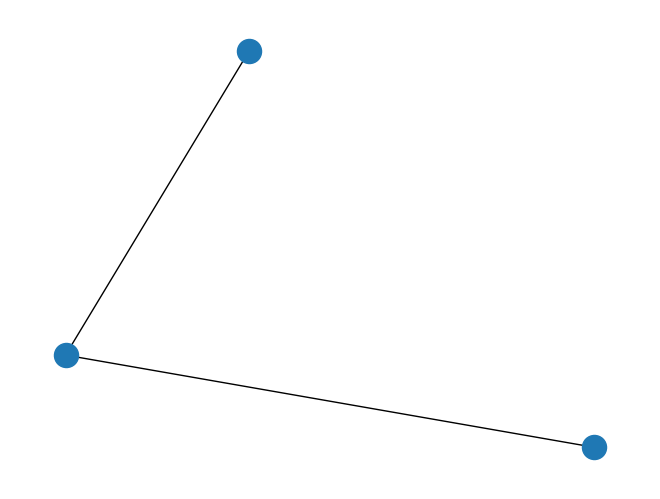

In [293]:
structure = read_structure("RF03000.structure")
seq_dict = read_sequences("RF03000.phylip")
graph = read_tree("RF03000.nwk")
simplified = simplify_struct(structure, "RF03000")

single_frequencies, paired_frequencies, singles_prob, paireds_prob = calc_frequencies(seq_dict, structure)
single_rate_matrix, paired_rate_matrix = calc_rate_matrix(graph, seq_dict, structure, single_frequencies, paired_frequencies, singles_prob, paireds_prob)

aligned_list = ["URS0000D68222_12908/1-125", "URS0000D6D017_12908/1-124"]
calc_column_prob(graph, single_frequencies, single_rate_matrix, aligned_list, ["C", "C"])
